<a href="https://colab.research.google.com/github/rkp74/Image_segmentation/blob/main/Self_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [ ]:
!pip install -I --no-cache-dir pillow

In [ ]:
!git clone https://github.com/tumble-weed/suriya-self-supervised.git
!mv suriya-self-supervised/*.py .
!rm -rf suriya-self-supervised
!wget -nc --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_" -O part_labels.zip && rm -rf /tmp/cookies.txt
!unzip -o part_labels.zip

DATA_ROOT = './'

# Unsupervised(Context Inpainting)

In [ ]:
import os.path as osp

import numpy as np
import cv2
import torch
from torch.utils import data
from random import shuffle
import os.path
import os
import copy
import math

In [ ]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn


from enc_dec import encoder_decoder
from utils import *
#from inpaint_utils import *
import matplotlib.pyplot as plt

Pre-training with Context Inpainting:



*   The model is initially trained in a self-supervised manner to inpaint missing parts of an image.
*   The missing parts are typically masked or replaced with a placeholder value (e.g., mean color) to simulate the "missing" information.
*   The network learns to generate content for these masked or missing regions based on the surrounding context or information present in the image.





In [ ]:
class ContextInpaintingDataset(data.Dataset):

    def __init__(self, img_root, image_list, mirror = True,
        context_shape = [32, 32], context_count = 4, split = 'train'):

        self.img_root = img_root
        self.split = split
        self.image_list = [line.rstrip('\n') for line in open(image_list)]

        self.mirror = mirror
        self.context_shape = context_shape
        self.context_count = context_count

        self.mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434]) # because we are reading using cv2
        self.std_bgr = 255*np.array([0.229, 0.224, 0.225])


        self.files = {}
        if self.split not in self.files.keys():
            self.files[self.split] = []
        for f in self.image_list:

            self.files[self.split].append({'img': img_root+f, 'lbl': 0})

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        image_file_name = self.img_root + self.image_list[index]

        image = None
        if os.path.isfile(image_file_name):
            image = cv2.imread(image_file_name)
        else:
            print('ERROR: couldn\'t find image -> ', image_file_name)

        if self.mirror: # randomly flip the image
            flip = torch.LongTensor(1).random_(0, 2)[0]*2-1 # complicated way of either -1, 1
            image = image[:, ::flip, :]

        ''' '''
        context_shape = self.context_shape
        context_mask = np.zeros((3, image.shape[0], image.shape[1]), np.uint8)

        ''' '''
        if self.context_count == 1:
            left = image.shape[0]/2 - context_shape[0]/2 #left of center patch
            context_mask[:, left:left+context_shape[0], left:left+context_shape[1]] = 1 # mask is made up ones
            image[left:left+context_shape[0], left:left+context_shape[1], 0] = self.mean_bgr[0] # put in mean values in this center
            image[left:left+context_shape[0], left:left+context_shape[1], 1] = self.mean_bgr[1] # put in mean values in this center
            image[left:left+context_shape[0], left:left+context_shape[1], 2] = self.mean_bgr[2] # put in mean values in this center

        else:
            orig_image = copy.deepcopy(image)
            for c_ in range(self.context_count):
                row = torch.LongTensor(1).random_(0, image.shape[0]-context_shape[0]-1)[0] # all valid locations for the left corner
                col = torch.LongTensor(1).random_(0, image.shape[1]-context_shape[1]-1)[0] # all valid locations for the left corner
                context_mask[:, row:row+context_shape[0], col:col+context_shape[1]] = 1
                image[row:row+context_shape[0], col:col+context_shape[1], 0] = self.mean_bgr[0]
                image[row:row+context_shape[0], col:col+context_shape[1], 1] = self.mean_bgr[1]
                image[row:row+context_shape[0], col:col+context_shape[1], 2] = self.mean_bgr[2]


        return self.transform_image(image), self.transform_mask(context_mask), self.transform_context(orig_image)

    def transform_image(self, image):
        # normalize the image by subtracting mean
        # why no need to divide by deviation?
        image = image.astype(np.float64)
        image -= self.mean_bgr
        image = image.transpose(2, 0, 1) # torch tensors are (batch,channel,row,col)
        image = torch.from_numpy(image.copy()).float()

        return image

    def transform_mask(self, mask):

        mask = torch.from_numpy(mask.copy()).float() # convert to tensor

        return mask

    def transform_context(self, context):
        # normalize the context by subtracting mean
        # divide standard deviation

        context = context.astype(np.float64)
        context -= self.mean_bgr
        context[:,:,0] /= 3*self.std_bgr[0]
        context[:,:,1] /= 3*self.std_bgr[1]
        context[:,:,2] /= 3*self.std_bgr[2]


        context[context>1] = 1 # limit values to -1 to 1
        context[context<-1] = -1

        context = context.transpose(2, 0, 1)
        context = torch.from_numpy(context.copy()).float()

        return context

In [ ]:
### define dataset paths
# what is the split of LFW?
train_img_root = DATA_ROOT + 'part_labels/data/all/'
train_image_list = DATA_ROOT + 'part_labels/splits/train_unlabeled_5k.txt'

val_img_root = DATA_ROOT + 'part_labels/data/all/'
val_image_list = DATA_ROOT + 'part_labels/splits/val_unlabeled_500.txt'

In [ ]:
train_loader = torch.utils.data.DataLoader(ContextInpaintingDataset(img_root = train_img_root,
                                                                  image_list = train_image_list, mirror = True),
                                           batch_size=16, num_workers=2, shuffle = True, pin_memory=False)

val_loader = torch.utils.data.DataLoader(ContextInpaintingDataset(img_root = val_img_root,
                                                                  image_list = val_image_list, mirror = True,split='val'),
                                           batch_size=16, num_workers=2, shuffle = False, pin_memory=False)

In [ ]:
net = encoder_decoder().cuda()
tanh = nn.Tanh() # to make the output within (-1 to 1)
experiment = 'self_supervised_pre_train_semantic_inpainting'


In [ ]:
print('Net params count (M): ', param_counts(net)/(1000000.0))


In [ ]:
use_cuda = torch.cuda.is_available()
best_loss = 9999  # best test accuracy

Inpainting Process:



*   During training, the inpainting network takes an image with masked regions as input and predicts the filled-in regions.
*   The model learns to generate content that fits well with the rest of the image, considering the context provided by the visible regions.






In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [30,40], gamma=0.1, last_epoch=-1) # learning rate starts from 0.1, 0.01 from 30, 0.001 from 40
trends = {'train_loss':[],
         'val_loss':[]}
for epoch in range(0, 50):

    '''
    Train
    '''

    print('\nTrain epoch: %d' % epoch)
    net.train()
    train_loss = 0
    for batch_idx, (inputs, masks, contexts) in enumerate(train_loader):
        if use_cuda:
            inputs, masks, contexts = inputs.cuda(), masks.cuda(), contexts.cuda()
        optimizer.zero_grad()
#         inputs = Variable(inputs)
#         masks = Variable(masks)
#         contexts = Variable(contexts)
        outputs = tanh(net(inputs))

        # no adversarial loss
        # look closely at the masked regions
        # and less importance is given to the rest of the image (to keep the results smooth)
        loss = 0.99*torch.mean(torch.mul((outputs - contexts)**2, masks)) + 0.01*torch.mean(torch.mul((outputs - contexts)**2, 1-masks))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = (train_loss/(batch_idx+1))
    print('Loss: %f '% train_loss)

    '''
    Val
    '''
    print('\nVal epoch: %d' % epoch)
    net.eval()
    val_loss = 0
    for batch_idx, (inputs, masks, contexts) in enumerate(val_loader):
        if use_cuda:
            inputs, masks, contexts = inputs.cuda(), masks.cuda(), contexts.cuda()
#         inputs = Variable(inputs)
#         masks = Variable(masks)
#         contexts = Variable(contexts)
        outputs = tanh(net(inputs))
        loss = 0.99*torch.mean(torch.mul((outputs - contexts)**2, masks)) + 0.01*torch.mean(torch.mul((outputs - contexts)**2, 1-masks))
        val_loss += loss.item()
    val_loss = (val_loss/(batch_idx+1))
    print('Loss: %f '% val_loss)
    # Save checkpoint.
    if val_loss < best_loss:
        print('Saving..')
        state = {'net': net}
        if not os.path.isdir(DATA_ROOT + 'checkpoint'):
            os.mkdir(DATA_ROOT + 'checkpoint')
        torch.save(state, DATA_ROOT + 'checkpoint/'+experiment+'ckpt.t7')
        best_loss = val_loss
    trends['train_loss'].append(train_loss)
    trends['val_loss'].append(val_loss)
    '''
    lr scheduler step
    '''
    lr_scheduler.step()


Train epoch: 0
Loss: 0.007423 

Val epoch: 0
Loss: 0.004195 
Saving..

Train epoch: 1
Loss: 0.004108 

Val epoch: 1
Loss: 0.003470 
Saving..

Train epoch: 2
Loss: 0.003628 

Val epoch: 2
Loss: 0.003266 
Saving..

Train epoch: 3
Loss: 0.003357 

Val epoch: 3
Loss: 0.003017 
Saving..

Train epoch: 4
Loss: 0.003180 

Val epoch: 4
Loss: 0.002912 
Saving..

Train epoch: 5
Loss: 0.003109 

Val epoch: 5
Loss: 0.002954 

Train epoch: 6
Loss: 0.002948 

Val epoch: 6
Loss: 0.002618 
Saving..

Train epoch: 7
Loss: 0.002779 

Val epoch: 7
Loss: 0.002516 
Saving..

Train epoch: 8
Loss: 0.002730 

Val epoch: 8
Loss: 0.002493 
Saving..

Train epoch: 9
Loss: 0.002601 

Val epoch: 9
Loss: 0.002440 
Saving..

Train epoch: 10
Loss: 0.002515 

Val epoch: 10
Loss: 0.002202 
Saving..

Train epoch: 11
Loss: 0.002406 

Val epoch: 11
Loss: 0.002367 

Train epoch: 12
Loss: 0.002348 

Val epoch: 12
Loss: 0.002268 

Train epoch: 13
Loss: 0.002315 

Val epoch: 13
Loss: 0.002574 

Train epoch: 14
Loss: 0.002260 



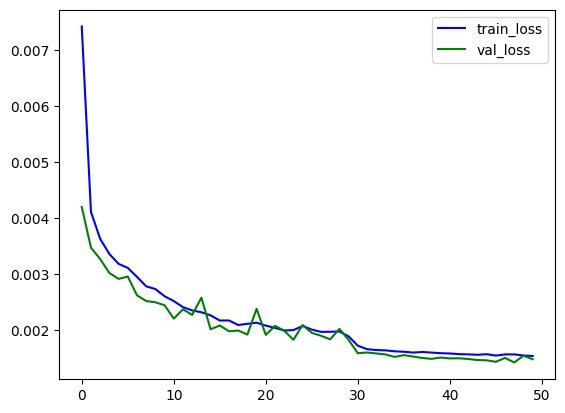

In [ ]:
plt.figure()
plt.plot(trends['train_loss'],color='b',label='train_loss')
plt.plot(trends['val_loss'],color='g',label='val_loss')
plt.legend()
plt.show()

In [ ]:
iter_val_loader = iter(val_loader)
inputs, masks, contexts = next(iter_val_loader)
if use_cuda:
    inputs, masks, contexts = inputs.cuda(), masks.cuda(), contexts.cuda()
#         inputs = Variable(inputs)
#         masks = Variable(masks)
#         contexts = Variable(contexts)
outputs = tanh(net(inputs))

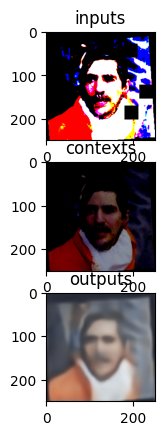

In [ ]:
# inputs = inputs.detach().cpu().numpy()
# input_im = np.transpose(inputs[0],(1,2,0))
# input_im = (input_im + 1)/2.

# contexts = contexts.detach().cpu().numpy()
# context_im = np.transpose(contexts[0],(1,2,0))
# # output_im = (output_im + 1)/2.


# outputs = outputs.detach().cpu().numpy()
# output_im = np.transpose(outputs[0],(1,2,0))
# output_im = (output_im + 1)/2.

# context_im = context_im[:,:,::-1]
# input_im = input_im[:,:,::-1]
# output_im = output_im[:,:,::-1]
# f,ax = plt.subplots(3)
# ax[0].imshow(input_im)
# ax[0].title.set_text('input')

# ax[1].imshow(context_im)
# ax[1].title.set_text('context')

# ax[2].imshow(output_im)
# ax[2].title.set_text('output')

# plt.show()

f,ax = plt.subplots(3)
for i,(t,n) in enumerate(zip([inputs,contexts,outputs],['inputs','contexts','outputs'])):
    im = t.detach().cpu().numpy()[0]
    im = np.transpose(im,(1,2,0))
    if n == 'outputs':
        im = (im+1)/2.
    else:
        mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])/255. # because we are reading using cv2
        std_bgr = np.array([0.229, 0.224, 0.225])

        im = im * 3*std_bgr[None,None,:]

    im = im[:,:,::-1]

    ax[i].imshow(im)
    ax[i].title.set_text(n)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Supervised(Semantic Segmentation)

Utilizing Inpainting for Segmentation:


*   After pre-training the inpainting model, the learned features and weights can be utilized for other tasks, such as semantic segmentation.
*   The pre-trained model, including the encoder and decoder, can be integrated into a segmentation network for further fine-tuning.
*   The pre-trained encoder can provide useful features for understanding the context of the image, which can enhance the segmentation performance.






___________________________________________________________________


 Semantic segmentation is the process of assigning a specific semantic label to each pixel in an image, dividing the image into distinct semantic categories. In this code, semantic segmentation is performed to classify each pixel into one of the predefined classes or categories relevant to the given dataset.



Dataset Preparation:

The code uses a dataset consisting of images and corresponding ground truth segmentation maps, where each pixel in the segmentation map is labeled with a specific class (semantic label).
Data Loaders:

Data loaders are used to load the training, validation, and test sets, preparing them for training and evaluation.
Model Architecture:

The neural network architecture used for semantic segmentation is based on an encoder-decoder design.
The encoder extracts features from the input image, while the decoder generates a segmentation mask based on those features.
Training for Semantic Segmentation:

The code trains the semantic segmentation model using different strategies, including training from scratch and fine-tuning with pre-trained parts.
The model is trained to predict the correct semantic label for each pixel in the input image.
Loss Function:

Cross-entropy loss is used as the loss function during training to measure the difference between predicted pixel-wise labels and ground truth labels.
Evaluation:

The model's performance is evaluated using metrics such as Mean Intersection over Union (mIoU), pixel accuracy, and frequency-weighted accuracy on a separate validation set.
Testing:

After training, the trained model is evaluated on a test set to measure its performance and obtain the final evaluation metrics for semantic segmentation.


In [ ]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
# from torch.autograd import Variable
import torch.nn as nn

### import other stuffs
from enc_dec import encoder_decoder
from loss import *
from utils import *

import matplotlib.pyplot as plt

DATA_ROOT = './'

In [ ]:
import numpy as np
import cv2
import torch
from torch.utils import data
from random import shuffle
import os.path
import collections



class SegmentationDataset(data.Dataset):

    def __init__(self, img_root, gt_root, image_list, split = 'train',
                     mirror = True, mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434]),
                     transform=True):

        np.random.seed(7)
        ### paths
        self.img_root = img_root
        self.gt_root = gt_root

        self.split = split

        ### list of all images
        self.image_list = [line.rstrip('\n') for line in open(image_list)]


        ### augmentations
        self.mirror = mirror


        self._transform = transform
        self.mean_bgr=mean_bgr

        self.files = {}
        for f in self.image_list:
            if self.split not in self.files.keys():
                self.files[self.split] = []
            self.files[self.split].append({'img': img_root+f, 'lbl': gt_root+f})

    def __len__(self):
        return len(self.files[self.split])


    def __getitem__(self, index):

        imname = self.image_list[index]
        imname = imname.replace('.png','.jpg')
        idt = imname[:-9]

#         idt = idt.replace('_',' ')
        image_file_name = self.img_root  + idt +'/'+imname
        seg_gt_name = self.gt_root + self.image_list[index]

        ### read image
        image = None
        if os.path.isfile(image_file_name):
            image = cv2.imread(image_file_name)
        else:
            print('ERROR: couldn\'t find image -> ', image_file_name)


        ### read segmentation gt as greyscale image
        seg_gt = None
        if os.path.isfile(seg_gt_name):
            gt = cv2.imread(seg_gt_name)
            seg_gt = np.zeros((gt.shape[0], gt.shape[1]), dtype=np.uint8)
            ind1 = np.where(gt[:,:,1] == 255)
            seg_gt[ind1] = 1
            ind2 = np.where(gt[:,:,2] == 255)
            seg_gt[ind2] = 2
        else:
            print('ERROR: couldn\'t find segmentation gt ->', seg_gt_name)


        ### apply mirroring
        if self.mirror:
            flip = torch.LongTensor(1).random_(0, 2)[0]*2-1
            image = image[:, ::flip, :]
            seg_gt = seg_gt[:, ::flip]



        ### shuffle list after epoch
        if index == len(self.image_list):
#             shuffle(self.indexlist) # mistake, should be image_list
            shuffle(self.image_list)

        if self._transform:
            return self.transform(image, seg_gt)



    def transform(self, img, lbl):
        img = img.astype(np.float64)
        img -= self.mean_bgr
        img = img.transpose(2, 0, 1)
        img = torch.from_numpy(img.copy()).float()
        lbl = torch.from_numpy(lbl.copy()).long()
        return img, lbl

In [ ]:
### define dataset paths
# train_img_root = DATA_ROOT + 'part_labels/data/images/'
train_img_root = DATA_ROOT + 'part_labels/data/all/'
train_gt_root = DATA_ROOT + 'part_labels/data/gt/'
train_image_list = DATA_ROOT + 'part_labels/splits/train_10p.txt'

# val_img_root = DATA_ROOT + 'part_labels/data/images/'
val_img_root = DATA_ROOT + 'part_labels/data/all/'
val_gt_root = DATA_ROOT + 'part_labels/data/gt/'
val_image_list = DATA_ROOT + 'part_labels/splits/minival.txt'

test_img_root = DATA_ROOT + 'part_labels/data/all/'
test_gt_root = DATA_ROOT + 'part_labels/data/gt/'
test_image_list = DATA_ROOT + 'part_labels/splits/test.txt'

nClasses = 3
mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])

In [ ]:
train_loader = torch.utils.data.DataLoader(SegmentationDataset(img_root = train_img_root, gt_root = train_gt_root,
                                                                  image_list = train_image_list, transform=True, mirror = True),
                                           batch_size=16, num_workers=2, shuffle = True, pin_memory=False)

val_loader = torch.utils.data.DataLoader(SegmentationDataset(img_root = val_img_root, gt_root = val_gt_root,
                                                                  image_list = val_image_list, transform=True, mirror = False),
                                           batch_size=16, num_workers=2, shuffle = False, pin_memory=False)

test_loader = torch.utils.data.DataLoader(SegmentationDataset(img_root = test_img_root, gt_root = test_gt_root,
                                                                  image_list = test_image_list, transform=True, mirror = False),
                                           batch_size=16, num_workers=2, shuffle = False, pin_memory=False)

In [ ]:
'''Experiment 1: train semantic segmentation network form scratch using 10% of training data'''
'''Initialize model with random weights (He initialization).'''
experiment = 'from_scratch'
net = encoder_decoder().cuda()

# 55.098452484703344 82.77928629989214 71.4377468041187

In [ ]:
'''Experiment 2: Fine-tune semantic segmentation network using pre-trained encoder (context prediction) using 10% of training data'''
'''Load the pre-trained encoder'''

experiment = 'from_relative_tiles_pre_training'
net = torch.load(DATA_ROOT + 'checkpoint/self_supervised_pre_train_semantic_inpaintingckpt.t7')['net']

upsample = nn.Upsample(scale_factor=2, mode='bilinear')

'''Add the decoder to the model. Note that the decoder is initialized with random weights'''
net.decoder = nn.Sequential(upsample, nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64),
                            upsample, nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(32),
                            upsample, nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=0, bias=False), nn.BatchNorm2d(16),
                            upsample, nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=0, bias=True))

net.cuda()

# 62.867514016826135 86.01381488673138 76.27833472519274

EncoderDecoder(
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (e_conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (e_bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (e_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (e_bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (e_bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e_conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (e_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (d_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:

os.listdir('checkpoint')

['self_supervised_pre_train_semantic_inpaintingckpt.t7']

In [ ]:
'''Experiment 3: Fine-tune semantic segmentation network using pre-trained encoder-decoder (context inpainting) using 10% of training data'''
'''Load the pre-trained encoder-decoder'''
net = torch.load(DATA_ROOT + 'checkpoint/self_supervised_pre_train_semantic_inpaintingckpt.t7')['net'].cuda()
experiment = 'from_semantic_inpainting_pre_training'
# 65.35361380810471 87.81917583603021 78.72283941521574

In [ ]:
print('Net params count (M): ', param_counts(net)/(1000000.0))

Net params count (M):  0.121251


In [ ]:
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [60,80], gamma=0.1, last_epoch=-1)

for epoch in range(0, 100):
    '''
    train
    '''
    print('\nTrain epoch: %d' % epoch)
    net.train()
    hist = np.zeros((nClasses, nClasses))+1e-12
    train_loss = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
#         inputs = Variable(inputs)
        outputs = net(inputs)

        loss = cross_entropy2d(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correctLabel = labels.view(-1, labels.size()[1], labels.size()[2])

        hist += fast_hist(correctLabel.view(correctLabel.size(0),-1).cpu().numpy(),
                        predicted.view(predicted.size(0),-1).cpu().numpy(),
                        nClasses)


        miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(train_loader),hist,train_loss/(batch_idx+1),is_train=True)


    miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(train_loader),hist,train_loss/(batch_idx+1),is_train=True)
    print('train: mIoU/Accuracy/Freqweighted_Accuracy', miou, p_acc, fwacc)

    '''
    validation
    '''

    print('\nVal epoch: %d' % epoch)

    net.eval()
    val_loss = 0
    hist = np.zeros((nClasses, nClasses))+1e-12
    for batch_idx, (inputs, labels) in enumerate(val_loader):
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

#         inputs = Variable(inputs)
        outputs = net(inputs)
        loss = cross_entropy2d(outputs, labels)

        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correctLabel = labels.view(-1, labels.size()[1], labels.size()[2])

        hist += fast_hist(correctLabel.view(correctLabel.size(0),-1).cpu().numpy(),
                        predicted.view(predicted.size(0),-1).cpu().numpy(),
                        nClasses)


        miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(val_loader),hist,val_loss/(batch_idx+1),is_train=False)



    miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(val_loader),hist,val_loss/(batch_idx+1),is_train=False)
    print('val: mIoU/Accuracy/Freqweighted_Accuracy', miou, p_acc, fwacc)

    # Save checkpoint.
    if p_acc > best_acc:
        print('Saving..')
        state = {'net': net}
        if not os.path.isdir(DATA_ROOT + 'checkpoint'):
            os.mkdir(DATA_ROOT + 'checkpoint')
        torch.save(state, DATA_ROOT + 'checkpoint/'+experiment+'ckpt.t7')
        best_acc = p_acc


    '''
    lr scheduler
    '''
    lr_scheduler.step()


Train epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


train: mIoU/Accuracy/Freqweighted_Accuracy 26.730622620204787 55.516021333333335 46.12655540842513

Val epoch: 0
val: mIoU/Accuracy/Freqweighted_Accuracy 27.605308320904754 56.861776 48.104606916443785
Saving..

Train epoch: 1
train: mIoU/Accuracy/Freqweighted_Accuracy 32.123229670560974 63.59327999999999 52.90704467592211

Val epoch: 1
val: mIoU/Accuracy/Freqweighted_Accuracy 40.75043751461338 70.641168 59.75683179020267
Saving..

Train epoch: 2
train: mIoU/Accuracy/Freqweighted_Accuracy 40.60952610475821 72.91293333333333 59.20746342871877

Val epoch: 2
val: mIoU/Accuracy/Freqweighted_Accuracy 49.986053755270035 79.202336 67.21594437345806
Saving..

Train epoch: 3
train: mIoU/Accuracy/Freqweighted_Accuracy 43.92218590428194 76.199488 61.62061582141298

Val epoch: 3
val: mIoU/Accuracy/Freqweighted_Accuracy 53.83504508967357 81.418208 69.93843356935659
Saving..

Train epoch: 4
train: mIoU/Accuracy/Freqweighted_Accuracy 47.33752362841037 79.095776 64.90999007852854

Val epoch: 4
val: mI

In [ ]:
net = torch.load(DATA_ROOT + 'checkpoint/'+experiment+'ckpt.t7')['net'].cuda().eval()

In [ ]:
def apply_color_map(x):
    img = np.zeros((x.shape[0], x.shape[1], 3), dtype = np.uint8)
    indices = np.where(x==0)

    img[indices[0], indices[1] ,2] = 255

    indices = np.where(x==1)
    img[indices[0], indices[1] ,1] = 255

    indices = np.where(x==2)
    img[indices[0], indices[1] ,0] = 255

    return img

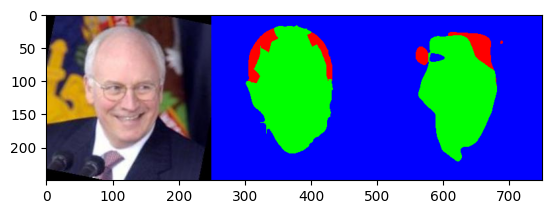

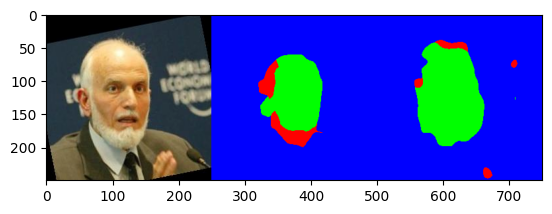

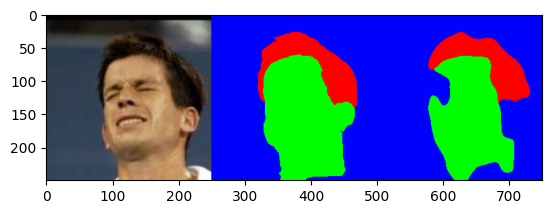

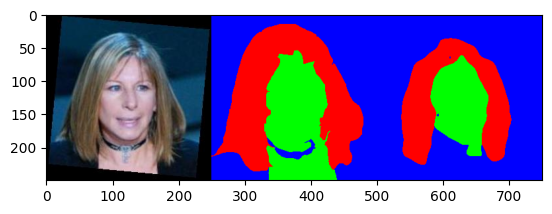

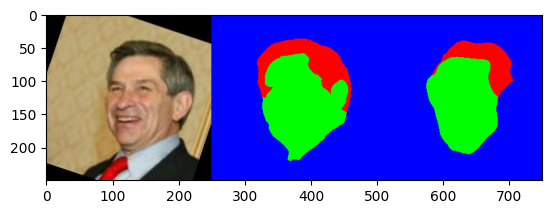

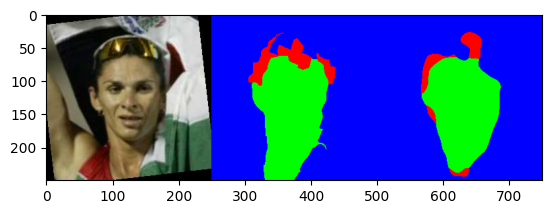

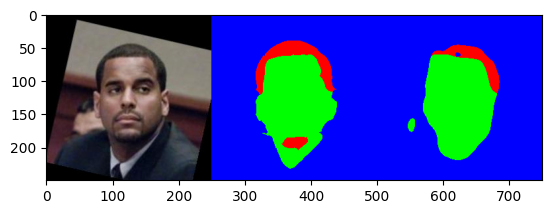

test: mIoU/Accuracy/Freqweighted_Accuracy 68.81691569381437 88.362208 79.51769129548933


In [ ]:
net.eval()
test_loss = 0
hist = np.zeros((nClasses, nClasses))+1e-12
for batch_idx, (inputs, labels) in enumerate(test_loader):
    if use_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
#     inputs = Variable(inputs)
    outputs = net(inputs)
    loss = cross_entropy2d(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)

    i = (inputs[0].data.cpu().numpy().transpose(1,2,0) + mean_bgr).astype(np.uint8)[:,:,::-1]
    g = apply_color_map(labels[0].cpu().numpy())
    o = apply_color_map(predicted[0].cpu().numpy())
    vis = np.concatenate((i,g,o), axis = 1)
    plt.imshow(vis)
    plt.show()

    correctLabel = labels.view(-1, labels.size()[1], labels.size()[2])

    hist += fast_hist(correctLabel.view(correctLabel.size(0),-1).cpu().numpy(),
                    predicted.view(predicted.size(0),-1).cpu().numpy(),
                    nClasses)


    miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(test_loader),hist,test_loss/(batch_idx+1),is_train=False)



miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(test_loader),hist,test_loss/(batch_idx+1),is_train=False)
print('test: mIoU/Accuracy/Freqweighted_Accuracy', miou, p_acc, fwacc)

# Automatic Program Repair



*   [Paper](https://arxiv.org/abs/2203.12755)
*   [Dataset](https://github.com/ASSERT-KTH/SelfAPR/tree/main/Samples_SelfAPR)




In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a synthetic dataset (replace this with real data)
def generate_dataset():
    # Input: buggy code snippets
    buggy_code = ['if (x > 10)', 'for i in range(10)', 'print(x / 0)']

    # Output: corresponding fixed code
    fixed_code = ['if (x >= 10)', 'for i in range(1, 11)', 'if x != 0: print(x / 0)']

    return buggy_code, fixed_code

# Feature extraction from code snippets
def extract_features(code_snippets):
    # This is a simplified example; in a real scenario, you'd extract meaningful features
    features = np.random.rand(len(code_snippets), 10)  # Random features for demonstration
    return features

# Train a model to predict fixes
def train_model(buggy_code, fixed_code):
    # Extract features
    buggy_features = extract_features(buggy_code)
    fixed_features = extract_features(fixed_code)

    # Concatenate features and labels
    X = np.concatenate((buggy_features, fixed_features), axis=1)
    y = np.ones(len(X))  # Labels (1 for fixed, 0 for buggy)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a classifier (e.g., Random Forest)
    classifier = RandomForestClassifier()
    classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print('Model Accuracy:', accuracy)

# Example usage
buggy_code, fixed_code = generate_dataset()
train_model(buggy_code, fixed_code)


In [ ]:
# Load and preprocess the supervised and unsupervised datasets
# ... (load and preprocess the datasets)

# For simplicity, let's assume we have preprocessed datasets: X_supervised, y_supervised, X_unsupervised

# Combine all data (supervised and unsupervised)
X_combined = np.concatenate((X_supervised, X_unsupervised), axis=0)
y_combined = np.concatenate((y_supervised, y_unsupervised), axis=0)

# Tokenize the code snippets and convert them to numerical sequences
# ... (implement code tokenization and numerical conversion)

# Let's assume we have tokenized data: X_combined_tokenized, y_combined_tokenized

# Split the combined data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_combined_tokenized, y_combined_tokenized, test_size=0.1, random_state=42)

# Define the neural network architecture
class CodeRepairModel(tf.keras.Model):
    def __init__(self, num_features, num_hidden_units, num_output_tokens):
        super(CodeRepairModel, self).__init__()

        # Encoder LSTM layer
        self.encoder = tf.keras.layers.LSTM(num_hidden_units, return_sequences=True)

        # Attention mechanism
        self.attention = tf.keras.layers.Attention()

        # Decoder LSTM layer
        self.decoder = tf.keras.layers.LSTM(num_hidden_units, return_sequences=True)

        # Output layer
        self.output_layer = tf.keras.layers.Dense(num_output_tokens, activation='softmax')

    def call(self, inputs):
        # Encoder
        encoder_output = self.encoder(inputs)

        # Attention mechanism
        context_vector, attention_weights = self.attention([encoder_output, encoder_output])

        # Decoder
        decoder_output = self.decoder(context_vector)

        # Output
        output = self.output_layer(decoder_output)

        return output, attention_weights

# Create the neural network model
model = CodeRepairModel(num_features=len(vocabulary), num_hidden_units=128, num_output_tokens=len(vocabulary))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)


In [ ]:
# Continuation of the code from the previous response

# Convert code snippets to numerical sequences (tokenization)
# ... (implement code tokenization and numerical conversion)

# Let's assume we have tokenized data: closure_buggy_code_tokenized

# Define the variational autoencoder model
class VariationalAutoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(latent_dim + latent_dim)  # Output mean and log variance
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(len(vocabulary), activation='sigmoid')
        ])

    def sample(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        z_mean, z_log_var = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=1)
        z = self.sample(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed

# Train the variational autoencoder
latent_dim = 64  # Dimension of the latent space
vae = VariationalAutoencoder(latent_dim)

vae.compile(optimizer='adam', loss='binary_crossentropy')

# Reshape the data for the autoencoder
closure_buggy_code_tokenized = np.array(closure_buggy_code_tokenized)
closure_buggy_code_tokenized = closure_buggy_code_tokenized.astype('float32') / max_token_value

# Train the VAE
vae.fit(closure_buggy_code_tokenized, closure_buggy_code_tokenized, epochs=10, batch_size=64)
